We first had to convert our music, which is contained in the midi format, to useable tokens which our transformer can process. Luckily we found the miditok library which does exactly that, it is a tokenizer that converts midi files into tokens.

In [2]:
from miditok import REMI
from pathlib import Path

# A validation method to discard MIDIs we do not want
def midi_valid(midi) -> bool:
    if any(ts.numerator != 4 for ts in midi.time_signature_changes):
        return False  # time signature different from 4/*, 4 beats per bar
    if midi.max_tick < 10 * midi.ticks_per_beat:
        return False  # this MIDI is too short
    return True

# Paths to the MIDI files paths to where the tokens will be saved
path_midi_files = 'data/dataset_small/'
path_tokens_noBPE = 'data/tokens_small_noBPE/'
path_tokens_BPE = 'data/tokens_small_BPE/'

# Creates the tokenizer and list the file paths
tokenizer = REMI(sos_eos=True)
midi_paths = list(Path(path_midi_files).glob('**/*.mid*'))

# Converts MIDI files to tokens saved as JSON files
tokenizer.tokenize_midi_dataset(        
    midi_paths,
    Path(path_tokens_noBPE),
    midi_valid
)

# Learns the BPE from non-BPE tokens
tokenizer.learn_bpe(
    path_tokens_noBPE,
    512,
    path_tokens_BPE
)

# Applies the learned BPE to the non-BPE tokens
tokenizer.apply_bpe_to_dataset(Path(path_tokens_noBPE), Path(path_tokens_BPE))

Learning byte pair encoding: 100%|██████████| 292/292 [09:25<00:00,  1.94s/it, seq_len_variation=-32.92, avg_nb_token_combs=2.63, max_nb_token_combs=4]


Mean of original lengths: 4342.993569131832
Mean length after BPE: 2913.4774919614147
Variation from original: -32.92 %


Applying BPE to dataset: 100%|██████████| 295/295 [01:58<00:00,  2.50it/s]


The tokenizer outputs the tokenized music as JSON files. We therefore had to convert them into numpy arrays, which we can further process.

In [6]:
import json
import numpy as np
import os

# Turns all the json files from tokenizaion in a folder into numpy arrays
def json_to_nparray(path):
    for filename in os.listdir(path):
        if filename.endswith('.json'):
            with open(path + filename) as f:
                data = json.load(f)
                np.save(path + filename[:-5], np.array(data))
            continue
        else:
            continue
        
json_to_nparray(path_tokens_BPE)

Due to the weird nested structure of the converted output from the tokenizer we had to write a function which de-nestifies our desired tokens so that we can put them in a single plain numpy array. Once that is done, we used np.save to save us this step because it could quite take some time with big datasets.

In [7]:
def get_tokens(path): # function to get all tokens from the dataset and put them in a numpy array
    to_shuffle = np.array(()) # to_shuffle aggregator for one piece
    data = np.array(()) # data aggregator for one piece
    piece_counter = 0
    
    for filename in os.listdir(path):
        if filename.endswith('.npy'):
            to_shuffle = np.append(to_shuffle, np.load(path + filename, allow_pickle=True)[()])
    np.random.shuffle(to_shuffle)
    
    for i in range(len(to_shuffle)):
        data = np.append(data, 1)
        for j in range(len(to_shuffle[i].get('tokens'))):
            data = np.append(data, to_shuffle[i].get('tokens')[j])
        data = np.append(data, 2)
        piece_counter += 1
        
    return data, piece_counter

tokens, piece_counter = get_tokens(path_tokens_BPE)

np.save(path_tokens_BPE, tokens)

Then we print some information about our tokens and plot how the tokens are distributed. Our number of tokens, which is also our vocab size, is 512 because we decided to have this size when learning the BPE for the tokens. Some tokens are missing, they just do not show up in the data. The learned BPE tokens start at value 220, so every token after that is a BPE token. The first big pile of tokens between value 0 and 100 are the tokens for all the pitches, the second smaller pile are tokens for velocity and after that we have the tokens for duration and position.

Number of tokens: 512
Missing tokens: {0, 178, 180, 182, 184, 91, 188}


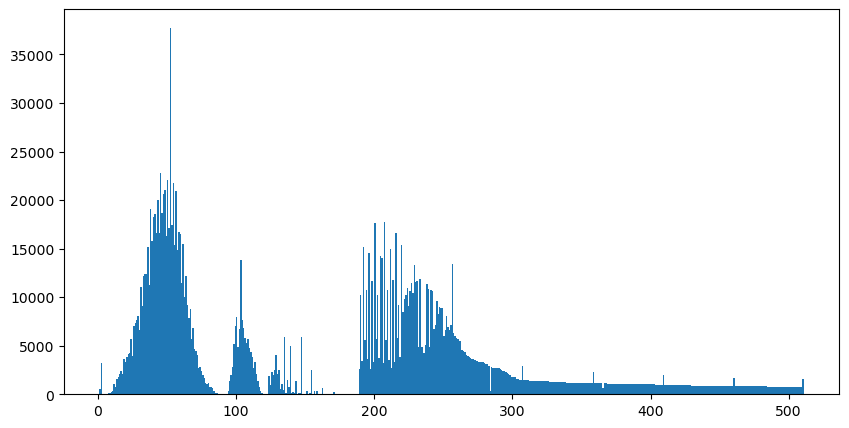

In [8]:
import matplotlib.pyplot as plt
# plot the distribution of the tokens
print(f'Number of tokens: {tokenizer.len}')
print(f'Missing tokens: {set(range(0, 512))-set(tokens)}')

plt.figure(figsize=(10, 5))
plt.hist(tokens, bins=500)
plt.show()

Then we go on doing the basic preprocessing of the data, where we have a 90:10 split for training and validation. Sequences are made of length seq_length, 
where we create input target pairs from the data. The input is a sequence of tokens and the target is the next token in the sequence up to seq_length. After that
the usual shuffling, batching and prefetching is done.


In [10]:
import tensorflow as tf

# create input and target sequences
def split_input_target(chunk): # split the input and the target
    input_text = chunk[:-1] # input is the sequence without the last token
    target_text = chunk[1:] # target is the sequence without the first token
    return input_text, target_text

# usual shuffling, batching and prefetching
def make_batches(ds, batch_size):
  return ds.shuffle(4096).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# function to create the dataset
def get_ds(npy_path, seq_length, batch_size):
    tokens = np.load(npy_path) # load the numpy array with all tokens
    data = tf.cast(tokens, tf.int32) # cast the tokens to int32
    n = int(0.9*len(data)) # split the data into train and validation 
    train_data = data[:n] # 90% train, 10% validation
    val_data = data[n:]  
    train_ds, val_ds = tf.data.Dataset.from_tensor_slices(train_data), tf.data.Dataset.from_tensor_slices(val_data) # create the dataset objects
    # create the input and target sequences
    train_ds, val_ds = train_ds.batch(seq_length+1, drop_remainder=True).map(split_input_target, tf.data.AUTOTUNE), val_ds.batch(seq_length+1, drop_remainder=True).map(split_input_target, tf.data.AUTOTUNE)
    # shuffle, batch and prefetch
    train_ds, val_ds = make_batches(train_ds, batch_size), make_batches(val_ds, batch_size)
    return train_ds, val_ds

Here is where the magic happens, our subclassed transformer architecture. 

In [11]:
# generate the position encoding
def positional_encoding(length, d_model):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# layer for embedding and positional encoding
class PostionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, block_size, dropout_rate):
        super(PostionalEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.block_size = block_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, 
                          output_dim=d_model, # each token gets a dmodel-vector embedding
                          input_length=block_size)
        self.pos_encoding = positional_encoding(block_size, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    @tf.function
    def call(self, x):
        x = self.embedding(x) + self.pos_encoding[:, :self.block_size, :]
        x = self.dropout(x)
        return x
    
# dot-product attention
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.head_size = d_model // n_heads
        self.key = tf.keras.layers.Dense(units=self.head_size, use_bias=False)
        self.query = tf.keras.layers.Dense(units=self.head_size, use_bias=False)
        self.value = tf.keras.layers.Dense(units=self.head_size, use_bias=False)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    @tf.function
    def call(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        # compute scores
        scores = tf.matmul(q,tf.transpose(k, perm=[0, 2, 1])) / tf.math.sqrt(tf.cast(self.head_size, tf.float32))
        tril = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
        scores = tf.where(tril == 0, tf.fill(tril.shape, -float('inf')), scores)
        scores = tf.nn.softmax(scores, axis=-1)
        scores = self.dropout(scores)
        # weighted sum of values
        return tf.matmul(scores, v)

# multi-head attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.heads = [ScaledDotProductAttention(d_model, n_heads, dropout_rate) for _ in range(n_heads)]
        self.dense = tf.keras.layers.Dense(units=d_model, use_bias=False)
    
    @tf.function
    def call(self, x):
        x = tf.concat([head(x) for head in self.heads], axis=-1)
        x = self.dense(x)
        return x
    
# feed-forward network
class FeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(FeedForwardNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=dff, activation=tf.nn.gelu, use_bias=False)
        self.dense2 = tf.keras.layers.Dense(units=d_model, use_bias=False)

    @tf.function
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# implementaion of SwiGLUFFN
class SwiGLUFFN(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(SwiGLUFFN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=(dff//3)*2, activation=tf.nn.silu, use_bias=False)
        self.dense2 = tf.keras.layers.Dense(units=(dff//3)*2, use_bias=False)
        self.dense3 = tf.keras.layers.Dense(units=d_model, use_bias=False)

    @tf.function
    def call(self, x):
        w = self.dense1(x)
        v = self.dense2(x)
        x = self.dense3(w*v)
        return x

# decoder layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.ffn = SwiGLUFFN(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.add = tf.keras.layers.Add()
    
    @tf.function
    def call(self, x):
        res_x = x
        x = self.layernorm1(x)
        x = self.mha(x)
        x = self.dropout(x)
        x = self.add([res_x, x])
        res_x = x
        x = self.layernorm2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x = self.add([res_x, x])
        return x
    
# decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size):
        super(Decoder, self).__init__()
        self.embedding = PostionalEmbedding(vocab_size, d_model, block_size, dropout_rate)
        self.layers = [DecoderLayer(d_model, n_heads, dff, dropout_rate) for _ in range(n_layers)]

    
    @tf.function
    def call(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return x
    
# transformer
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size):
        super(Transformer, self).__init__()
        self.decoder = Decoder(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size)
        self.final_dense = tf.keras.layers.Dense(units=vocab_size)
    
    @tf.function
    def call(self, x):
        x = self.decoder(x)
        logits = self.final_dense(x)
        return logits
    
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


These are the hyperparameter for our model. 

In [12]:
d_model = 96 # also embedding size
dff = 384 # inner feedforward layer dim
n_heads = 8 # number of heads in the multihead attention layer
n_layers = 6 # number of layers
dropout_rate = 0.1 # dropout rate
epochs = 200 # number of epochs
seq_length = 2048 # length of the sequence
batch_size = 16 # batch size
vocab_size = tokenizer.len # size of the vocabulary

For the learning rate we used a learning rate scheduler according to the attention is all you need paper. The learning rate increases linearly depending on the number of warmup steps (in our case 4000). After that the learning rate decreases like a root function.

Text(0.5, 0, 'Train Step')

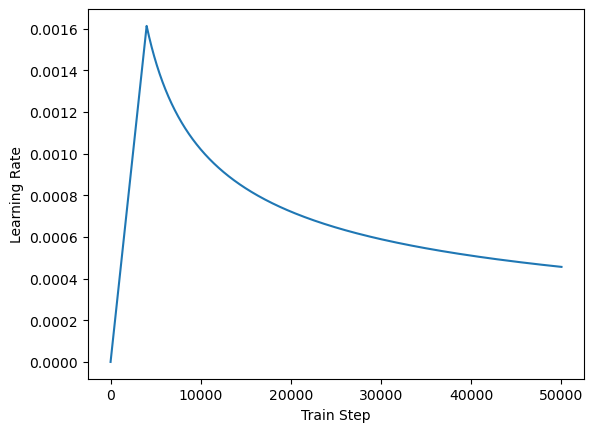

In [13]:
learning_rate = CustomSchedule(d_model)
plt.plot(learning_rate(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

Here comes the training procedure.

In [ ]:
import datetime

# our masked loss function
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

# our masked accuracy function
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

# filepath to data
small_data = 'data/SMALL_2M_BPE.npy'

# create dataset objects from data
train_ds, val_ds = get_ds(small_data, seq_length, batch_size)

# learning rate schedule
learning_rate = CustomSchedule(d_model)

# optimizer as defined in the paper attention is all you need
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=2e-9)

# create the model
model = Transformer(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, seq_length)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = '/checkpoints/data2Mparams1.3M/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=100)

# create a log directory for tensorboard
logdir = "/logs/data7Mparams2M/fit/"
log_dir = logdir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# start tensorboard
%tensorboard --logdir "/content/drive/My Drive/iannwtf_project/clean/logs/data7Mparams1.3M/fit/"

# compile the model
model.compile(optimizer=optimizer, loss=masked_loss, metrics=[masked_accuracy])

# train the model
model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[tensorboard_callback, cp_callback])

As last step we have to use our trained model to generate token sequences and then convert them back into a midi file so that we can listen to what we have achieved.

In [ ]:
# function to generate the tokens sampling from the logits
def generate_tokens_sampling(model, start_token, max_len):
    for i in range(max_len):
        logits = model(start_token) # generate logits for the next token
        start_token_numpy = start_token.numpy() # convert the tensor to numpy array
        start_token_numpy[:, i+1] = tf.random.categorical(logits[:,i], num_samples=1).numpy() # sample a token from the logits and add it to the sequence
        start_token = tf.constant(start_token_numpy, dtype=tf.int64) # convert the numpy array to tensor
        if start_token_numpy[:, i+1] == 2: # stop when the end token is predicted
            break
    return start_token

# max_len is seq_length - 1 because the first token has to be the start token
max_len = seq_length - 1
# start token is a tensor with the first token being the start token and the rest being 0
start_token = tf.constant([[1] + [0] * (max_len)], dtype=tf.int64)
# then we generate the tokens with our sampling function
sampled_tokens = generate_tokens_sampling(model, start_token, max_len)
# and finally we convert the tokens to midi
tokenizer(sampled_tokens, [(0, False)]).dump(f'sample_song {datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.mid')